In [1]:
from tqdm import tqdm_notebook

import numpy as np
np.random.seed(1)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

try : 
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
except : 
    import nltk
    nltk.download('vader_lexicon')  
    vader = SentimentIntensityAnalyzer()
    
import warnings
warnings.simplefilter("ignore")

/home/hfcp/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
model = api.load("glove-twitter-50")

[=====---------------------------------------------] 11.9% 23.8/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 27.3% 54.5/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.7% 85.2/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 50.0% 99.8/199.5MB downloaded

In [3]:
lemma_dict = model.key_to_index
vectors = model.vectors

<AxesSubplot:title={'center':'l2-norm'}>

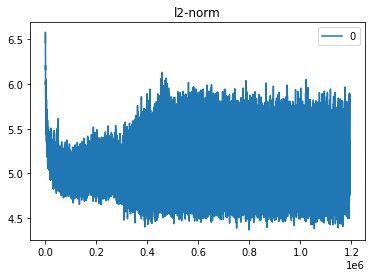

In [4]:
norm_dist = np.linalg.norm(vectors, axis=1)
pd.DataFrame(norm_dist).rolling(100).mean().plot(title='l2-norm')

In [5]:
from sklearn.preprocessing import normalize
vectors = normalize(vectors, axis=1)

___

its pretrained vector space can be said orthogonal

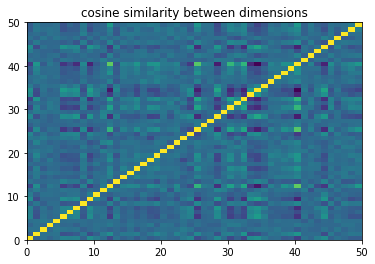

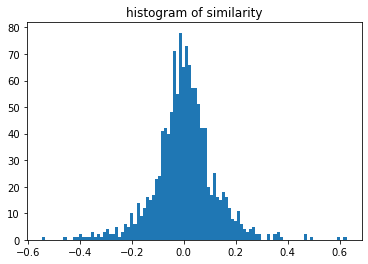

In [6]:
cossim_mat = cosine_similarity(vectors.transpose(1,0))
plt.title("cosine similarity between dimensions")
plt.pcolor(cossim_mat)
plt.show()

cossim_mat[np.tril_indices_from(cossim_mat)] = np.nan
plt.title("histogram of similarity")
_ = plt.hist(cossim_mat[np.isfinite(cossim_mat)], bins=100)
plt.show()

____

In [7]:
def get_word_candidates(init, sim_const) :
    cand = []
    for w in model.similar_by_word(init) : 
        if w[1] > sim_const : 
            cand.append(w[0])
    return cand

iteratively search sentiment vocab

In [8]:
pos_container = []
cand = get_word_candidates('great', sim_const=0.75) # positiv word init
pos_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(pos_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        pos_container += value

neg_container = []
cand = get_word_candidates('bad', sim_const=0.75) # negative word init
neg_container += cand
iters = 3

for proc in range(iters) :
    cand = list(set(neg_container))
    for query in cand : 
        value = get_word_candidates(query, sim_const=0.75)
        neg_container += value
        
sentiment_vocab = list(set(pos_container).union(set(neg_container)))
print("===" * 10)
print("The # of positive words picked :", len(set(pos_container)))
print("The # of negative words picked :", len(set(neg_container)))
print("The # of sentimental words picked :", len(sentiment_vocab))
print("The # of intersection between pos/neg :", len(set(pos_container).intersection(set(neg_container))))
print("===" * 10)

The # of positive words picked : 484
The # of negative words picked : 359
The # of sentimental words picked : 649
The # of intersection between pos/neg : 194


In [9]:
sentiment_idx = [v for k,v in lemma_dict.items() if k in sentiment_vocab]
notsentiment_idx = [v for k,v in lemma_dict.items() if k not in sentiment_vocab]
positive_idx = [v for k,v in lemma_dict.items() if k in set(pos_container)]
negative_idx = [v for k,v in lemma_dict.items() if k in set(neg_container)]

# to easy-compare and visualize, I sampled the same number for indexes from ~sentiment candidates
# since it gives stochasticity in research, we need to do sampling multiple times for more robust result 
notsentiment_idx = np.random.choice(notsentiment_idx, len(sentiment_idx), replace=False)

In [10]:
notsentiment_vector = vectors[notsentiment_idx]
sentiment_vector = vectors[sentiment_idx]

____

In [11]:
def calc_ztest(dist1, dist2) : 
    mean1 = np.mean(dist1)
    mean2 = np.mean(dist2)
    std1 = np.std(dist1)
    std2 = np.std(dist2)
    return (mean1-mean2)/np.sqrt(std1**2+std2**2)

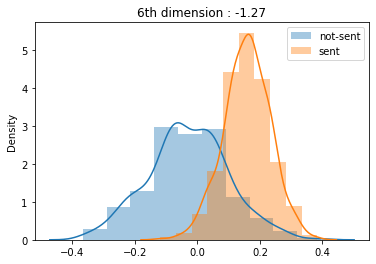

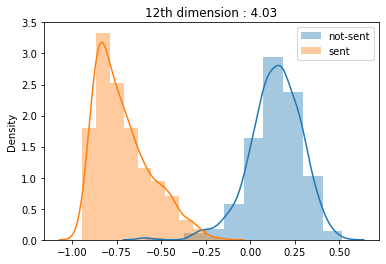

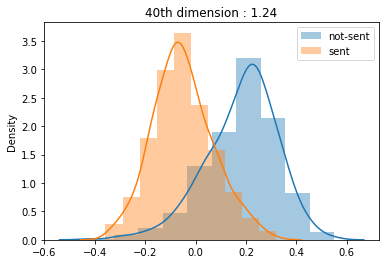

In [12]:
embed_dim = vectors.shape[1]
score_mem = []

for idx in range(embed_dim) : 
    score = np.round(calc_ztest(notsentiment_vector[:,idx], sentiment_vector[:,idx]), 2)    
    if np.abs(score) >= 1 : 
        score_mem.append(idx)
        plt.title("{}th dimension : {}".format(idx, score))    
        _ = sns.distplot(notsentiment_vector[:,idx], bins=10, label='not-sent')
        _ = sns.distplot(sentiment_vector[:,idx], bins=10, label='sent')
        plt.legend()
        plt.show()

In [14]:
vocab_ls = list(lemma_dict.keys())
word_from_dist1 = [vocab_ls[idx] for idx, b in enumerate((vectors[:,12] < -.6) & (vectors[:,12] > -1)) if b]
sent_from_dist1 = [vader.polarity_scores(w)['compound'] for w in word_from_dist1]
no_sentiment_corpus = [i for i in sent_from_dist1 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist1)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.1869


In [15]:
vocab_ls = list(lemma_dict.keys())
word_from_dist2 = [vocab_ls[idx] for idx, b in enumerate((vectors[:,12] < .4) & (vectors[:,12] > 0)) if b]
sent_from_dist2 = [vader.polarity_scores(w)['compound'] for w in word_from_dist2]
no_sentiment_corpus = [i for i in sent_from_dist2 if i != 0]
ratio = len(no_sentiment_corpus)/len(word_from_dist2)
print("Sentimental word ratio : {}".format(np.round(ratio, 4)))

Sentimental word ratio : 0.0007


____

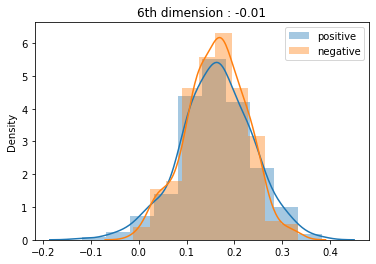

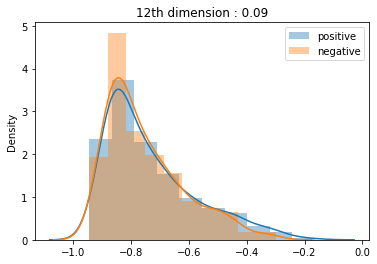

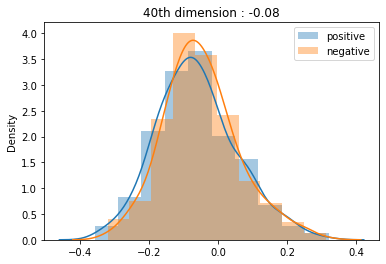

In [16]:
for idx in score_mem : 
    dist1 = vectors[positive_idx][:,idx]
    dist2 = vectors[negative_idx][:,idx]
    score = np.round(calc_ztest(dist1, dist2), 2)    
    
    plt.title("{}th dimension : {}".format(idx, score))
    _ = sns.distplot(dist1, bins=10, label='positive')
    _ = sns.distplot(dist2, bins=10, label='negative')
    plt.legend()
    plt.show()